
## Radar signal simulator
## ECE 435/535 Winter 2020
## -------------------
## Samantha Fink , Jacob Pratt
## Date: 03/13/2020
## -------------------


### HW:
This homework is for getting familiar with interacting with data. You are going to write a few functions. The functions that you are writing are relively simple. The basic simulator is supplied. I suggest you exercise it change a few functions. You have two method of adding funtions. You can either add them near the top in the #Custom Fuction# block or in the <i><b>LastName.py</b></i> file 


#### Jupyter Modifications 
1. Add probablity of detection function

1. Add fuction to detect/generate new noise floor after gating and summing

1. Use probability of detection function to determine threshold

1. What is last peak?: **The last peak on the plot is the start of the next pulse.**
    
1. Convert plot to dBm

1. Replace find_peaks with a thresholding function

### Functions to add
1. Probablity of False Positive 
1. Find noise floor from data
1. SNR Threshold function
1. Report number of targets and distance

In [1]:
'''Method: -- this is a script..
1 - Create a pulse train from Transmitter
2 - Generate a list of targets, (Range, RCS)
3 - Generate return pulses for each of the targets into a single train
4 - Attenuate 1 to reasonable power level
5 - Add 3+4
6 - Add AGWN to 5
7 - Apply detection method
'''

from matplotlib import pyplot as plt
import numpy as np
import scipy.signal as sig

# Custom libraries
import pulsetrain as pt
import pulsenoise as pn
import detection as det
import math
import scipy.constants as const

# Student Libary
import lastname as GPD # Intials (George P. Burdell)


## Student Custom Library 

In [2]:
def myfuction(var1, var2='1942', var3='Chain Home'):
    print(var1, var2, var3)
    x = 42
    return x, var1

# usage
derp0, derp1 = myfuction(23,'1939')
print('\n================')
print(derp0, derp1)

23 1939 Chain Home

42 23


### Setup the RADAR parameters

In [3]:
Pavg = 100e3        # Basic Power level output of the radar
Gt = 15             # Scalar Gain of TX antenna
Gr = Gt             # Scalar Gain of RX antenna  if Gr == Gt same antenna
fc = 40e6           # Carrier Frequency, Center Frequency
vp = 3e8            # Phase Velocity of the EM wave
NF = 1              # Receiver Noise Figure
T  = 1/fc           # period of one Carrier Frequency
#derived values
Lambda = vp/fc

# Setup Time portion
PRF = 500           # Pulses per second (hertz)
PRI = 1/PRF         # Pulse Repetition Interval (seconds)
R_unamb = PRI *vp/2 # Unambiguous Range

#Num cycles per pulse packet
k = 100             # k cycles of fc in the pulse packet
PW = k*T            # k cycles * Period of fc
BW = 1/PW           # Bandwidth of the RADAR Pulse
# error check
if PW >= PRI:
    print('Error: Pulse width much too long -- PRI: {}, PW = {}'.format(PRI, PW))


### Find R-max, R-umabigous

In [4]:
# calculate maximum range with SNR = 1, n Observations = 1
SNRmin = 1
RCS = 1
Rmax = pt.calcRmax(Pavg,Gt,Gr,Lambda, BW, SNRmin = SNRmin, RCS = RCS) #, RCS, T, NF = 1,L=1, SNRmin=1)
print('Rmax(SNR:{}, RCS:{}) \t= {:.02f} km'.format(SNRmin, RCS, Rmax/1e3))
print('R unambigous \t\t= {:.02f}km'.format(R_unamb/1e3))


Rmax(SNR:1, RCS:1) 	= 141.16 km
R unambigous 		= 300.00km


# Setup the testing enviroment

In [5]:
num_targets = 10

target_ranges = np.random.randint(Rmax//4,Rmax,num_targets)
target_rcs = np.random.randint(1,1000,num_targets)


#### Time series Constraints

In [6]:
K_pulses = 20 # how many PRI's get simulated
dt_k = 20 # how many samples per fc period (Tc)

#### Build the sample Pulse Train and examine

In [7]:
# Make a signal smaller in amplitude to simulate the 
# blanking / attenuation in normal RADAR systems


attenuate = True
if attenuate == True:
    dBm = -100 #dBm
    scalar = 1e-3 * np.power(10,(dBm/10))
else:
    scalar = Pavg
    
main_train, PW, dt, len_PRI = pt.createPulseTrain(A=scalar,fc = fc, k=k, PRI=PRI, dt_k=dt_k, K_pulses = K_pulses)



=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Amplitude -100.00 dBm, fc:40000000.0, k:100, PRI:0.002, dt_k:20, K_pulses:20 


### Create the target reflections

In [8]:
# Now we create the returns...
main_trace = np.zeros_like(main_train) # return without TX

for idx, target_range in enumerate(target_ranges):

    pwr, dbm = pt.RadarEquationAdv(Pavg, Gt, target_range, RCS, Gr, Lambda, dB=False)
    print(':: idx: {} Power at RX {} dBm @ range: {} rmax {}'.format(idx,(10*np.log10(Pavg/1e-3)),
                                                                     target_range, R_unamb ))
    p_train, PW, dt, len_PRI = pt.createPulseTrain(A=pwr,fc = fc, k=k, PRI=PRI,
                                                   dt_k=dt_k, K_pulses = np.int(K_pulses))
    # time shift to correct spot
    p_train = pt.timeShift(p_train, target_range,vp, dt, len_PRI)
    main_trace = main_trace + p_train

:: idx: 0 Power at RX 80.0 dBm @ range: 112556 rmax 300000.0
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Amplitude -78.64 dBm, fc:40000000.0, k:100, PRI:0.002, dt_k:20, K_pulses:20 
600298
:: idx: 1 Power at RX 80.0 dBm @ range: 127491 rmax 300000.0
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Amplitude -91.28 dBm, fc:40000000.0, k:100, PRI:0.002, dt_k:20, K_pulses:20 
679952
:: idx: 2 Power at RX 80.0 dBm @ range: 47255 rmax 300000.0
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Amplitude -98.24 dBm, fc:40000000.0, k:100, PRI:0.002, dt_k:20, K_pulses:20 
252026
:: idx: 3 Power at RX 80.0 dBm @ range: 46069 rmax 300000.0
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Amplitude -98.49 dBm, fc:40000000.0, k:100, PRI:0.002, dt_k:20, K_pulses:20 
245701
:: idx: 4 Power at RX 80.0 dBm @ range: 83373 rmax 300000.0
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*

#### Merge the Transmitter Pulse train (main_train) with the reflected signals (main_trace)

#### add AWGN to the total Pulse train with returns

In [9]:
# -------------------------------
# now we add the two systems together.
# Add noise to the pulse traing
main_trace = main_trace + main_train
main_trace = pn.addNoiseToPulseTrain(main_trace,1/PW)

## 1. Probability of detection function



In [10]:
#Using defined SNR = 1, n Observations = 1 assumptions from "Find R-max, R-umabigous" section:
SNR = 1 
N = 1
Wi = math.exp(-((SNR)*math.sqrt(N)))
print('False positive probability = {}'.format(Wi))

False positive probability = 0.36787944117144233


## 2. Find noise floor from data

In [11]:
# -------------------------------
# Detection Section
# Envelope detect the signals
main_trace_env = det.envelope(main_trace)

# -------------------------------
# Gate the signal & sum them up for 
# provide n observation effects
n_obs_main_trace_env = main_trace_env.reshape(K_pulses+1, len_PRI)
# add them all together
n_obs_main_trace_env = n_obs_main_trace_env.sum(axis=0)

noisefloor = np.average(main_trace_env)
print('Noise floor:',noisefloor)

Noise floor: 3.8664671791505275e-14


## 3. SNR Threshold Data

In [12]:
from scipy.signal import find_peaks
dBm = -100 #dBm
scalar = 1e-3 * np.power(10,(dBm/10))
thresh = 0.36787944117144233
peaks,_ = find_peaks(n_obs_main_trace_env,height=thresh/1e11, distance = 15e3)
dbm = 10*np.log10(n_obs_main_trace_env/1e3)

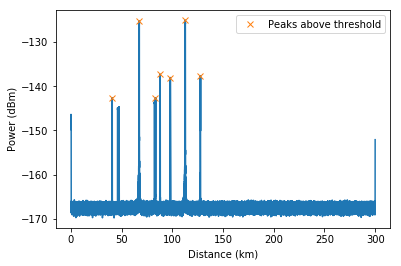

In [13]:
# make the distance vector
nsamps = len(n_obs_main_trace_env)
x = np.linspace(0,R_unamb, nsamps)
dx = R_unamb/(len(n_obs_main_trace_env))
x=x/1e3


plt.plot(x,dbm)
plt.plot(peaks*dx/1e3, dbm[peaks],'x', label="Peaks above threshold")


plt.title('')
plt.xlabel('Distance (km)')
plt.ylabel('Power (dBm)')
plt.legend()

peakVals = sig.find_peaks(peaks*dx, n_obs_main_trace_env[peaks])


## 4. Report number of targets and distance


In [14]:
print('Number of targets:',len(peaks))
print('Distances of targets (in km)', (peaks*dx/1e3))

Number of targets: 7
Distances of targets (in km) [ 40.5076875  67.1998125  83.3746875  87.7858125  97.738875  112.55775
 127.492875 ]
